In [2]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split

''' Provides an abstraction of a data point as a Euclidean point with (x,y) coordinates. '''
class Point2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return '(' + str(self.x) + ',' + str(self.y) + ')'
    
    def __repr__(self):
        return self.__str__()
    
    def minus(self, point):
        return Point2D(self.x - point.x, self.y - point.y)
    
    ''' Returns the point in the given list that is closest (in terms of Euclidean distance) to this point. '''
    def closest_point(self, points):
        shortest_dist = float('inf')
        closest_point = 0
        for point in points:
            dist = math.sqrt((point.x - self.x)**2 + (point.y - self.y)**2)
            if dist < shortest_dist:
                shortest_dist = dist
                closest_point = point
        return closest_point
    
    ''' Returns the point that is closest to the average of the given list of Point objects. '''
    def average_point(self, points):
        avg_x = 0.
        avg_y = 0.
        for point in points:
            avg_x += point.x
            avg_y += point.y
        avg_x /= len(points)
        avg_y /= len(points)

        avgPt = Point2D(avg_x, avg_y)
        closestToAvg = avgPt.closest_point(points)
        return closestToAvg
    
    ''' Creates a scatterplot of the given clusters, color-coding by cluster and highlighting centroids in red. '''
    def plot_clusters(self, points, clusters):
        colors = ['blue', 'green', 'cyan', 'magenta', 'yellow', 'black']
        centroids = clusters.keys()
        
        for centroid in clusters:
            x, y = [], []
            for point in clusters[centroid]:
                if point != centroid:
                    x.append(point.x)
                    y.append(point.y)
            plt.scatter(x, y, color=colors[centroids.index(centroid) % len(colors)])
            
        x, y = [], []
        for centroid in centroids:
            x.append(centroid.x)
            y.append(centroid.y)
        plt.scatter(x, y, color='red')
        plt.show()

/Users/anthonydepalatis/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
''' Provides an abstraction of a data point as a Euclidean point with (x,y,z) coordinates. '''
class Point3D:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
    def __str__(self):
        return '(' + str(self.x) + ',' + str(self.y) + ',' + str(self.z) + ')'
    
    def __repr__(self):
        return self.__str__()
    
    def minus(self, point):
        return Point3D(self.x - point.x, self.y - point.y, self.z - point.z)
    
    def closest_point(self, points):
        shortest_dist = float('inf')
        closest_point = 0
        for point in points:
            dist = math.sqrt((point.x - self.x)**2 + (point.y - self.y)**2 + (point.z - self.z)**2)
            if dist < shortest_dist:
                shortest_dist = dist
                closest_point = point
        return closest_point
    
    def average_point(self, points):
        avg_x = 0.
        avg_y = 0.
        avg_z = 0.
        for point in points:
            avg_x += point.x
            avg_y += point.y
            avg_z += point.z
        avg_x /= len(points)
        avg_y /= len(points)
        avg_z /= len(points)
        
        avgPt = Point3D(avg_x, avg_y, avg_z)
        closestToAvg = avgPt.closest_point(points)
        return closestToAvg
    
    ''' Creates a scatterplot of the given clusters, color-coding by cluster and highlighting centroids in red. '''
    def plot_clusters(self, points, clusters):
        colors = ['blue', 'green', 'cyan', 'magenta', 'yellow', 'black']
        centroids = clusters.keys()
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for centroid in clusters:
            x, y, z = [], [], []
            for point in clusters[centroid]:
                if point != centroid:
                    x.append(point.x)
                    y.append(point.y)
                    z.append(point.z)
            ax.scatter(x, y, z, color=colors[centroids.index(centroid) % len(colors)])
            
        x, y, z = [], [], []
        for centroid in centroids:
            x.append(centroid.x)
            y.append(centroid.y)
            z.append(centroid.z)
        ax.scatter(x, y, z, color='red')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.show()

In [4]:
''' K medioids centroid initialization. '''
def init_k_medioids(points, k):
    return random.sample(points, k)

In [5]:
''' Kmeans++ centroid initialization. '''
def init_kpp(points, k):
    # Choose first centroid uniformly at random
    centroids = [random.choice(points)]
    
    # Choose the remaining k-1 centroids
    for i in range(1, k):
        # For each point, calculate the squared distance between it and the closest already-chosen centroid
        distances = [None for j in range(len(points))]
        for j in range(len(points)):
            closest_cent = points[j].closest_point(centroids)
            distances[j] = (closest_cent.x - points[j].x)**2 + (closest_cent.y - points[j].y)**2

        # Generate probability weights proportional to the previously calculated squared distances
        weights = [distances[j] / sum(distances) for j in range(len(distances))]

        # Choose a new centroid randomly from the remaining points 
        centroids.append(np.random.choice(points, p=weights))

    return centroids

In [6]:
''' Performs the k-means clustering algorithm using the given centroid initialization method. '''
def k_means(centroid_init_func, points, k):
    # Initialize the centroids by randomly choosing k points from the dataset
    centroids = centroid_init_func(points, k)
    previous_centroids = []
    
    # Assign clusters and reassign centroids until they stop changing
    while centroids != previous_centroids:
        previous_centroids = [cent for cent in centroids]
        clusters = {cent: [cent] for cent in centroids}
        
        # Assign each point to the closest centroid
        for point in points:
            if point not in centroids:
                # Find the centroid closest to the point and add it to its cluster
                closest_cent = point.closest_point(centroids)
                clusters[closest_cent].append(point)
                
        # Plot the current clusters
        #points[0].plot_clusters(points, clusters)
                
        # Keep track of the previous set of centroids
        last_centroids = centroids

        # Reassign centroids 
        for centroid in clusters:
            centroids.append(centroid.average_point(clusters[centroid]))    # Assign the new centroid
            centroids.remove(centroid)    # Delete the old centroid
            
    return points, clusters

In [7]:
''' Creates scatter plots of the two data sets. '''
def plot_datasets(moons, chains):
    x, y = [], []
    for point in moons:
        x.append(point.x)
        y.append(point.y)
    plt.scatter(x, y)
    plt.title('two_moons')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = [], [], []
    for point in chains:
        x.append(point.x)
        y.append(point.y)
        z.append(point.z)
    ax.scatter(x, y, z)
    plt.title('linked_chains')
    plt.show()

In [8]:
def calc_sim_matrix(points):
    sim_matrix = np.zeros(shape=(len(points), len(points)))
    for i in range(len(points)):
        for j in range(len(points)):
            diff = points[i].minus(points[j])
            entry = math.sqrt(diff.x**2 + diff.y**2)
            sim_matrix[i][j] = entry
    return sim_matrix

In [9]:
''' Read the data and separate labels and data. '''
two_moons = pd.read_csv('/Users/anthonydepalatis/Documents/School/EE379K/Lab6/data/two_moons.csv', header=None)
linked_chains = pd.read_csv('/Users/anthonydepalatis/Documents/School/EE379K/Lab6/data/linked_chains.csv', header=None)

moons_labels = two_moons[0]
moons_data = np.array(two_moons.drop(0, axis=1))
moons_data = [Point2D(moons_data[k][0], moons_data[k][1]) for k in range(len(moons_data))]

chains_labels = linked_chains[0]
chains_data = np.array(linked_chains.drop(0, axis=1))
chains_data = [Point3D(chains_data[k][0], chains_data[k][1], chains_data[k][2]) for k in range(len(chains_data))]

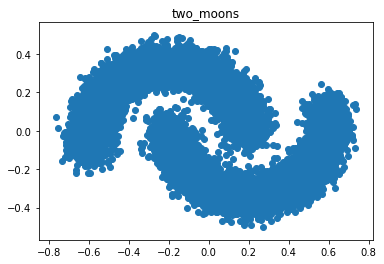

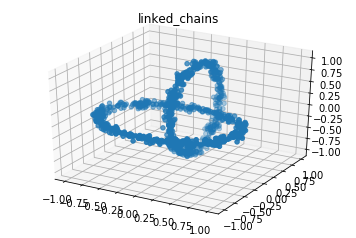

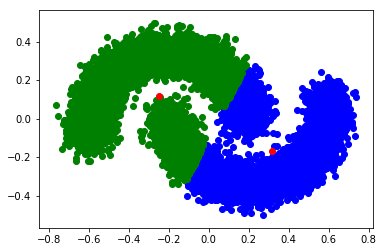

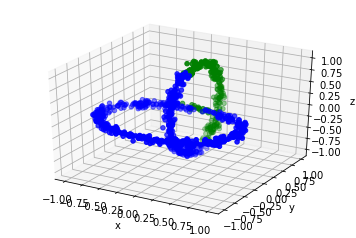

Done!


In [12]:
''' PART 1 - Plot the raw data. '''
plot_datasets(moons_data, chains_data)

''' PART 2 - Run K-Means on both sets and plot the resulting clusters. '''
points, clusters = k_means(init_k_medioids, moons_data, 2)
points[0].plot_clusters(points, clusters)

points, clusters = k_means(init_k_medioids, chains_data, 2)
points[0].plot_clusters(points, clusters)

''' PART 3 - Spectral clustering. '''
A_moon = calc_sim_matrix(moons_data)
print 'Done!'